# 과제 4


## 0. 문제정의:

    * 과제4: 
        * 머신러닝 문제 정의: 주택정보를 이용하여 블럭당 주택가격의 중앙값을 예측하는 수치예측(회귀)
        * 평가지표: R2 0.8을 목표치로 설정

## 1. 데이터 수집 및 적재
    * 대용량의 데이터인 경우에는 literater(Chunksize 지정) 등 기술을 이용

In [67]:
import pandas as pd
import numpy as np

In [68]:
housing = pd.read_csv('../datasets/housing.csv')
housing.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## 2. EDA 
    * EDA를 통해 누락값 처리, 이상치 처리, 특성 스케일링 처리를 위한 정책을 수립한다.

In [69]:
# !pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


In [70]:
# 변수 간 상관관계 파악해보기
import seaborn as sns
import matplotlib.pyplot as plt

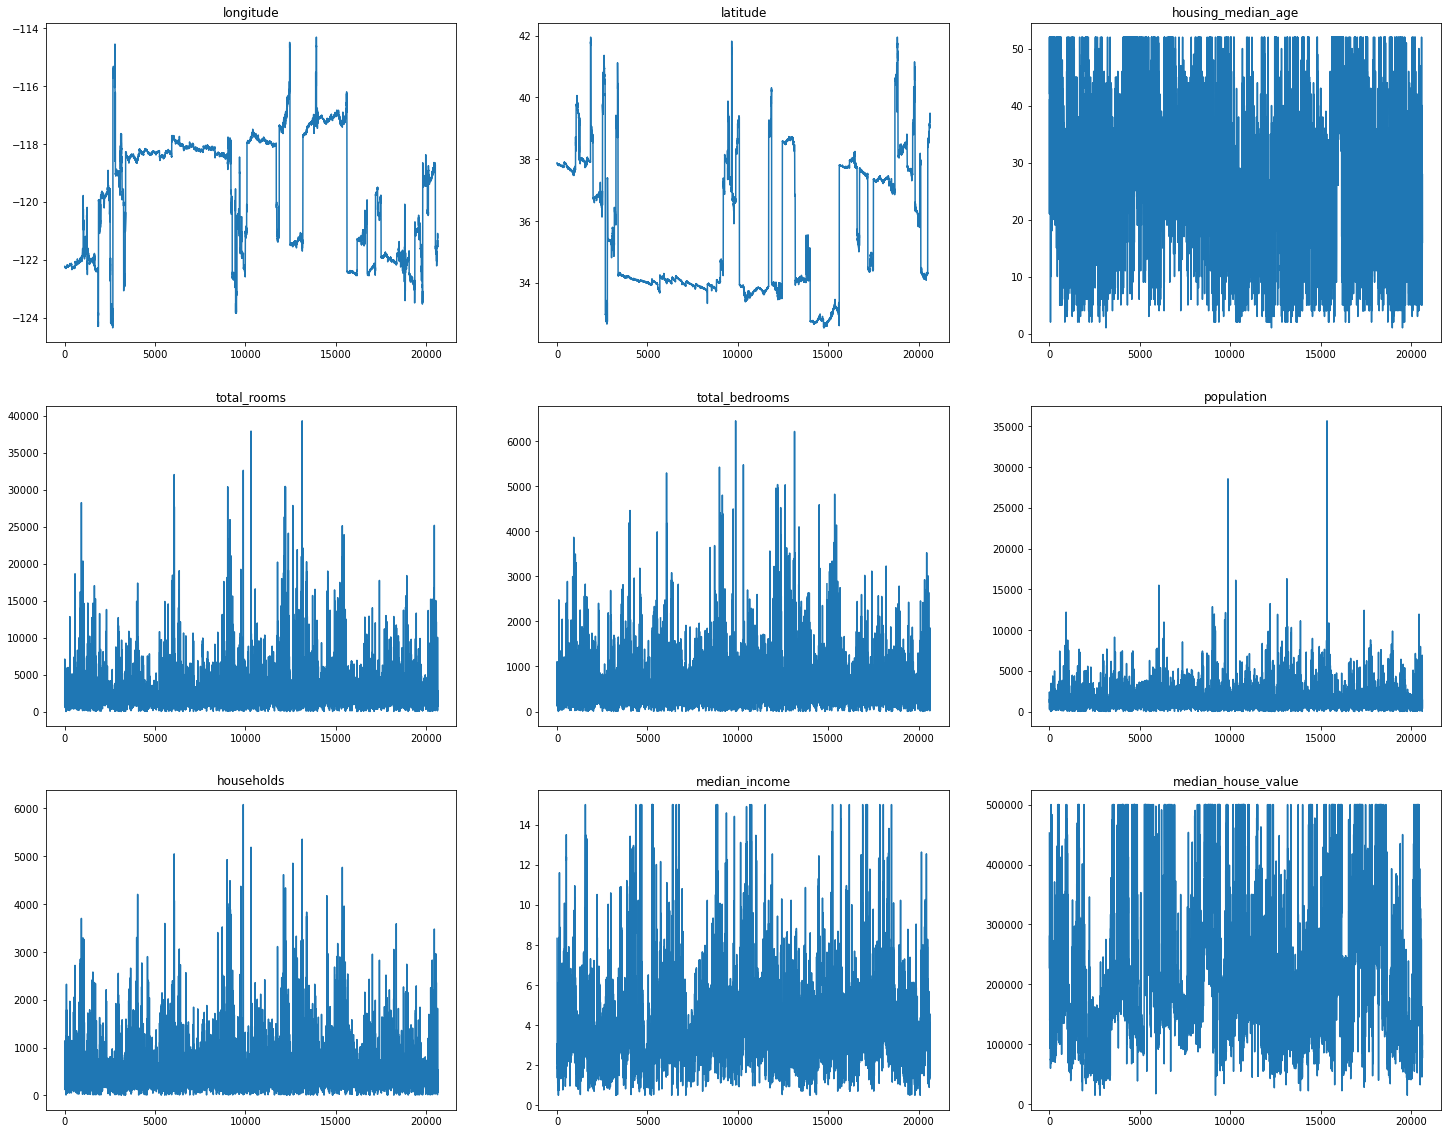

In [71]:
# (3,3) subplot으로 만들어보기

fig, ax = plt.subplots(3, 3,figsize = (25,20))
num_axcolumns = 3
for i, cname in enumerate(housing.iloc[:,:-1].columns):
    
    row_idx = i // num_axcolumns
    col_idx = i % num_axcolumns
    
    housing.iloc[:,:-1][cname].plot(ax=ax[row_idx, col_idx])
    ax[row_idx, col_idx].set_title(cname)
plt.show()

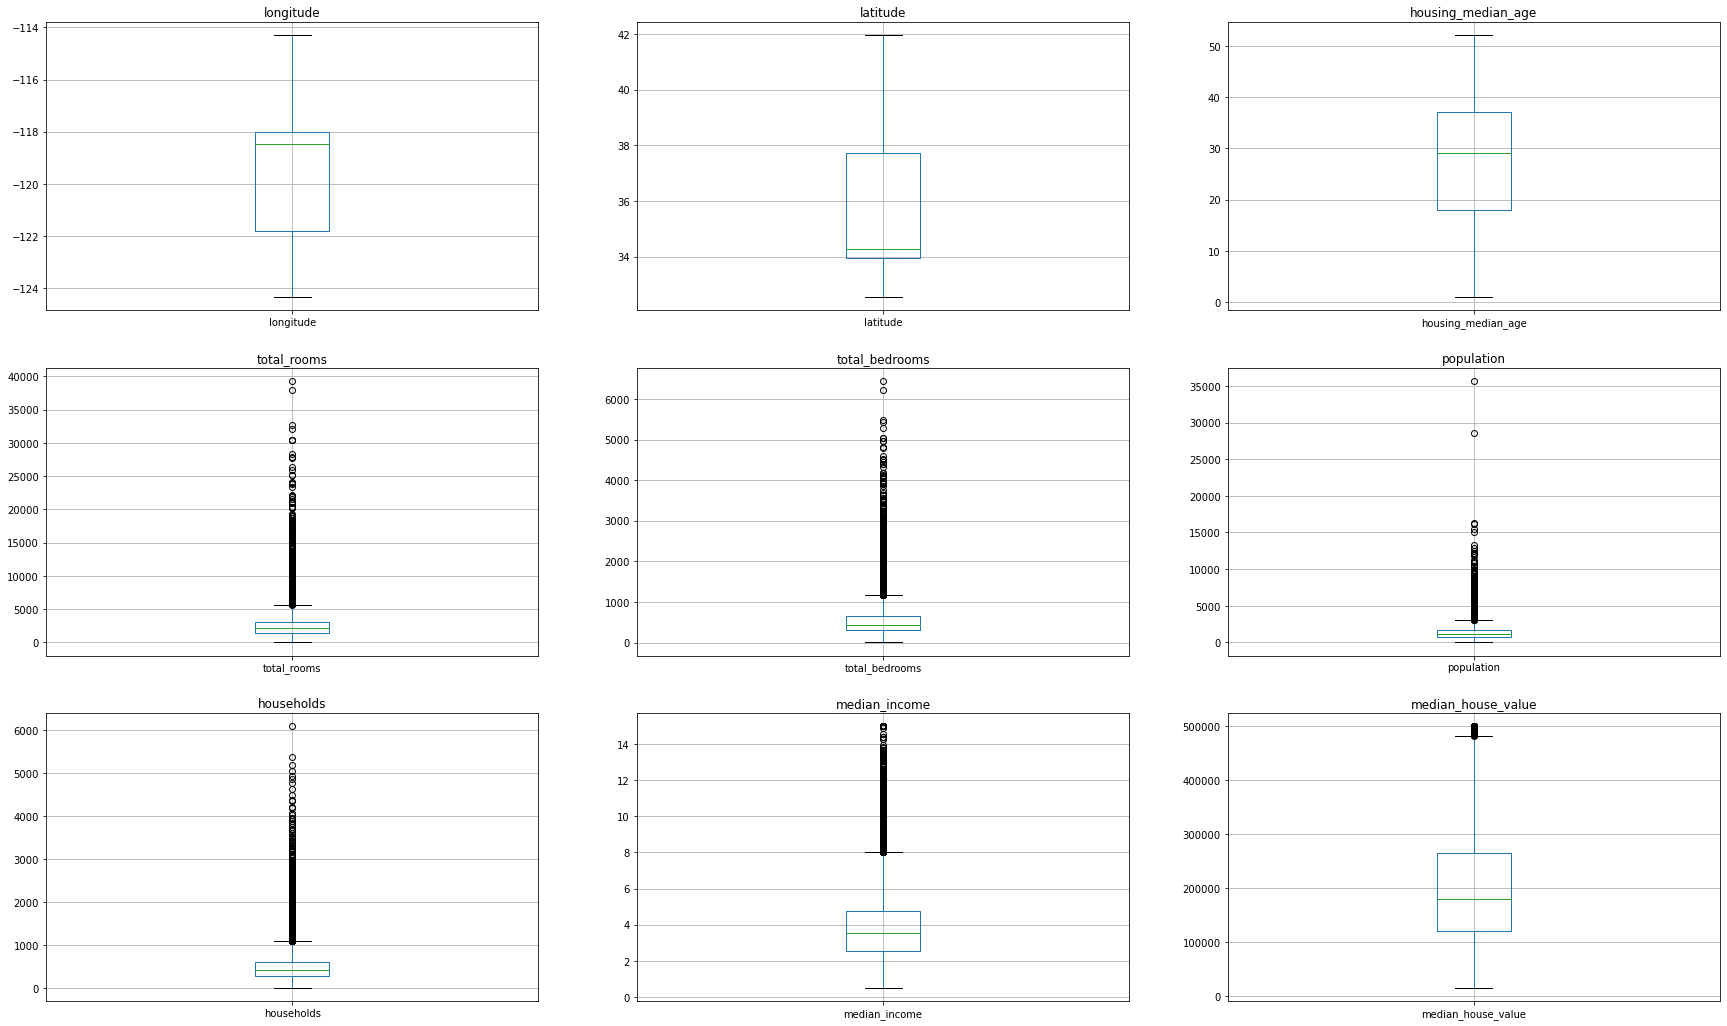

In [72]:
# (3,3) subplot으로 만들어보기 - boxplot

fig, ax = plt.subplots(3, 3,figsize = (30,18))
num_axcolumns = 3
for i, cname in enumerate(housing.iloc[:,:-1].columns):
    
    row_idx = i // num_axcolumns
    col_idx = i % num_axcolumns
    
    housing.iloc[:,:-1][[cname]].boxplot(ax=ax[row_idx, col_idx]) ## 박스플롯에 맞게 
    
    ax[row_idx, col_idx].set_title(cname)
plt.show()

## 3. 전처리
    * 데이터를 전처리 하세요.
        * Missing value 나 outlier 를 확인하고 처리하세요.
        * 항목형이나 명목형 속성을 벡터화(수치화) 처리하세요.
        * activity 가 label 입니다.

In [73]:
class DataFrameSelector():
    def __init__(self, attribs):
        self.attribs = attribs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.loc[:, self.attribs] ### 의미있는 변환을 하는 부분
    
    def fit_transform(self, X, y=None):
        return self.transform(X, y)

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

housing = pd.read_csv('../datasets/housing.csv')
X = housing.drop(columns=['median_house_value'], axis='columns')
y = housing['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
cat_columns = ['ocean_proximity']

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_columns)),
        ('imputer', KNNImputer(n_neighbors=7)),
        ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_columns)),
        ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

full_pipeline.fit(X_train)
X_train_prep = full_pipeline.transform(X_train)
X_test_prep = full_pipeline.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16512, 9) (16512,) (4128, 9) (4128,)


In [129]:
# 이상치 처리 해주는 사용자 정의 변환기 by shbaek

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin

class MyOutlierTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.q1 = np.quantile(X, 0.25, axis=0)        
        self.q3 = np.quantile(X, 0.75, axis=0)
        print(self.q1.shape, self.q3.shape)
        self.iqr = self.q3 - self.q1
        self.upper = self.q3 + 1.5*self.iqr
        self.lower = self.q1 - 1.5*self.iqr
        return self
    
    def transform(self, X, y=None):
        X_ = np.where(X > self.upper, self.upper, X)
        X_ =  np.where(X_ < self.lower, self.lower, X_)
        return X_

In [130]:
selector = Pipeline([
        ('selector', DataFrameSelector(num_columns)),
        ('imputer', KNNImputer(n_neighbors=7)),
])

out_updator = Pipeline([
        ('selector', DataFrameSelector(num_columns)),
        ('imputer', KNNImputer(n_neighbors=7)),
        ('outlier_updater', MyOutlierTransformer()),
])

<AxesSubplot:>

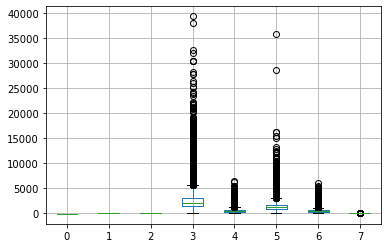

In [131]:
selector.fit(housing)
housing_num = selector.transform(housing)
pd.DataFrame(housing_num).boxplot()

(8,) (8,)


<AxesSubplot:>

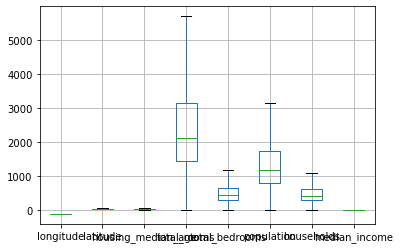

In [132]:
out_updator.fit(housing)
housing_wo_outlier = out_updator.transform(housing)
pd.DataFrame(housing_wo_outlier, columns=num_columns).boxplot()

# 수치예측(회귀)

In [77]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_columns)),
        ('imputer', KNNImputer(n_neighbors=7)),
        ('scaler', StandardScaler()),
])

Pipeline(steps=[('selector',
                 <__main__.DataFrameSelector object at 0x00000214BEACCF70>),
                ('imputer', KNNImputer(n_neighbors=7)),
                ('scaler', StandardScaler())])

In [92]:
# 그리드 탐색 활용
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_columns)),
        ('imputer', KNNImputer(n_neighbors=7)),
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
])

param_grid = [{'scaler':[None], 'regressor':[LinearRegression()]}, # 1가지 조합
              {'scaler':[StandardScaler(), MinMaxScaler(), None], 
               'regressor':[Lasso()], 
              'regressor__alpha':[5, 1, 0.5]},  # 3 x 1 x 3: 9가지 조합
              {'scaler':[None], 
              'regressor':[RandomForestRegressor()], 
              'regressor__n_estimators':[30, 50], 
              'regressor__max_features':[0.6]}, # 1, 1, 2, 1: 2가지 조합
             ]
grid = GridSearchCV(num_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selector',
                                        <__main__.DataFrameSelector object at 0x00000214BE865940>),
                                       ('imputer', KNNImputer(n_neighbors=7)),
                                       ('scaler', StandardScaler()),
                                       ('regressor', LinearRegression())]),
             param_grid=[{'regressor': [LinearRegression()], 'scaler': [None]},
                         {'regressor': [Lasso()],
                          'regressor__alpha': [5, 1, 0.5],
                          'scaler': [StandardScaler(), MinMaxScaler(), None]},
                         {'regressor': [RandomForestRegressor(max_features=0.6,
                                                              n_estimators=50)],
                          'regressor__max_features': [0.6],
                          'regressor__n_estimators': [30, 50],
                          'scaler': [None]}],
             scoring='neg_mean_squared_error')

In [97]:
grid.best_params_

{'regressor': RandomForestRegressor(max_features=0.6, n_estimators=50),
 'regressor__max_features': 0.6,
 'regressor__n_estimators': 50,
 'scaler': None}

In [98]:
import pandas as pd
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_scaler,param_regressor__alpha,param_regressor__max_features,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.100969,0.004071,0.024392,0.002734,LinearRegression(),None,NaN,NaN,NaN,"{'regressor': LinearRegression(), 'scaler': None}",-5.239597e+09,-5.031371e+09,-4.990365e+09,-4.629448e+09,-4.604637e+09,-4.899084e+09,2.454319e+08,11
1,0.503181,0.020615,0.026728,0.003241,Lasso(),StandardScaler(),5,NaN,NaN,"{'regressor': Lasso(), 'regressor__alpha': 5, ...",-5.239370e+09,-5.031393e+09,-4.990513e+09,-4.629475e+09,-4.604549e+09,-4.899060e+09,2.453973e+08,5
2,0.391322,0.031696,0.029323,0.004398,Lasso(),MinMaxScaler(),5,NaN,NaN,"{'regressor': Lasso(), 'regressor__alpha': 5, ...",-5.232394e+09,-5.032912e+09,-4.995256e+09,-4.631197e+09,-4.604322e+09,-4.899216e+09,2.436810e+08,12
3,0.869050,0.023659,0.027922,0.002820,Lasso(),None,5,NaN,NaN,"{'regressor': Lasso(), 'regressor__alpha': 5, ...",-5.239670e+09,-5.031370e+09,-4.990362e+09,-4.629424e+09,-4.604590e+09,-4.899083e+09,2.454682e+08,8
4,0.585012,0.027812,0.028354,0.003251,Lasso(),StandardScaler(),1,NaN,NaN,"{'regressor': Lasso(), 'regressor__alpha': 1, ...",-5.239552e+09,-5.031375e+09,-4.990395e+09,-4.629453e+09,-4.604619e+09,-4.899079e+09,2.454249e+08,6
5,0.448401,0.024057,0.027829,0.002688,Lasso(),MinMaxScaler(),1,NaN,NaN,"{'regressor': Lasso(), 'regressor__alpha': 1, ...",-5.238076e+09,-5.031613e+09,-4.991253e+09,-4.629731e+09,-4.604504e+09,-4.899036e+09,2.450728e+08,3
6,0.987747,0.049152,0.028923,0.003278,Lasso(),None,1,NaN,NaN,"{'regressor': Lasso(), 'regressor__alpha': 1, ...",-5.239612e+09,-5.031371e+09,-4.990365e+09,-4.629443e+09,-4.604628e+09,-4.899084e+09,2.454392e+08,9
7,0.612793,0.023375,0.028524,0.001352,Lasso(),StandardScaler(),0.5,NaN,NaN,"{'regressor': Lasso(), 'regressor__alpha': 0.5...",-5.239574e+09,-5.031373e+09,-4.990380e+09,-4.629451e+09,-4.604628e+09,-4.899081e+09,2.454284e+08,7
8,0.485356,0.020156,0.027335,0.001479,Lasso(),MinMaxScaler(),0.5,NaN,NaN,"{'regressor': Lasso(), 'regressor__alpha': 0.5...",-5.238832e+09,-5.031488e+09,-4.990804e+09,-4.629585e+09,-4.604566e+09,-4.899055e+09,2.452518e+08,4
9,0.959337,0.036689,0.027012,0.002461,Lasso(),None,0.5,NaN,NaN,"{'regressor': Lasso(), 'regressor__alpha': 0.5...",-5.239605e+09,-5.031371e+09,-4.990365e+09,-4.629446e+09,-4.604632e+09,-4.899084e+09,2.454355e+08,10


In [101]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_columns)),
        ('imputer', KNNImputer(n_neighbors=7)),
        ('scaler', None),
        ('regressor', RandomForestRegressor(max_features=0.6, n_estimators=50))
])

In [105]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [102]:
num_pipeline.fit(X_train, y_train)

Pipeline(steps=[('selector',
                 <__main__.DataFrameSelector object at 0x00000214C7124760>),
                ('imputer', KNNImputer(n_neighbors=7)), ('scaler', None),
                ('regressor',
                 RandomForestRegressor(max_features=0.6, n_estimators=50))])

In [103]:
num_pipeline.score(X_train, y_train)

0.9734441322978388

In [104]:
num_pipeline.score(X_test, y_test)

0.8257907491850294